In [1]:
import os
import pytz
import datetime 
import requests
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import time
import plotly.express as px
import plotly.io as pio
from scipy import stats

pio.renderers.default = "notebook"
pd.set_option('display.max_columns', 500)

In [2]:
conn = sqlite3.connect('data_cache/process_gambling_v1.db')
df_in = pd.read_sql("""
SELECT 
    event_id,
    team,
    season,
    team_name,
    opponent,
    is_home,
    week_no,
    event_start,
    overtime,
    team_score,
    opponent_score,
    team_score > opponent_score team_win,
    team_score - opponent_score team_margin,
    ABS(team_score - opponent_score) team_margin_abs,
    (team_score + team_spread) > opponent_score team_win_ats,
    (team_score + team_spread) - opponent_score team_margin_ats,
    ABS( (team_score + team_spread) - opponent_score ) team_margin_ats_abs,
    (opponent_score + opponent_spread) > team_score opponent_win_ats,
    team_score + opponent_score total_score,
    (team_score + opponent_score) > over_points over_win,
    team_spread,
    ABS(team_spread) team_spread_abs,
    team_spread_price,
    1 - 1/team_spread_price team_spread_prob,
    opponent_spread,
    opponent_spread_price,
    over_points,
    over_price,
    under_points,
    under_price,
    over_points - (team_score + opponent_score) over_margin,
    ABS(over_points - (team_score + opponent_score)) over_margin_abs
FROM (
    -- Convert from home / away to team / opponent
    SELECT
        events.event_id,
        events.team,
        events.team_name,
        CASE WHEN 
            events.team_name = attr.home_team 
            THEN attr.away_team ELSE attr.home_team 
        END opponent,
        events.team_name = attr.home_team is_home, 
        -- Game attributes
        attr.week_no,
        events.event_start,
        events.season,
        attr.overtime,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.home_score ELSE attr.away_score END team_score,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.away_score ELSE attr.home_score END opponent_score,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.home_spread ELSE attr.away_spread END team_spread,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.home_spread_price ELSE attr.away_spread_price END team_spread_price,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.away_spread ELSE attr.home_spread END opponent_spread,
        CASE WHEN events.team_name = attr.home_team
        THEN attr.away_spread_price ELSE attr.home_spread_price END opponent_spread_price,
        over_points,
        over_price,
        under_points,
        under_price
    FROM SILVER_EVENTS_LOOKUP_americanfootball_nfl events
    JOIN (
        -- Coalesce spreads for a given market
        SELECT
        odds.event_id,
            scores.kickoff_datetime event_start,
            scores.season,
            scores.week_no,
            scores.home_team,
            scores.away_team,
            CAST(scores.home_score AS INTEGER) home_score,
            CAST(scores.away_score AS INTEGER) away_score,
            scores.overtime,
            COALESCE(odds.home_spread_point_draftkings_db0, odds.home_spread_point_draftkings_db1) home_spread,
            COALESCE(odds.home_spread_price_draftkings_db0, odds.home_spread_price_draftkings_db1) home_spread_price,
            COALESCE(odds.away_spread_point_draftkings_db0, odds.away_spread_point_draftkings_db1) away_spread,
            COALESCE(odds.away_spread_price_draftkings_db0, odds.away_spread_price_draftkings_db1) away_spread_price,
            COALESCE(odds.over_total_point_draftkings_db0, odds.over_total_point_draftkings_db1) over_points,
            COALESCE(odds.over_total_price_draftkings_db0, odds.over_total_price_draftkings_db1) over_price,
            COALESCE(odds.under_total_point_draftkings_db0, odds.under_total_point_draftkings_db1) under_points,
            COALESCE(odds.under_total_price_draftkings_db0, odds.under_total_price_draftkings_db1) under_price
        FROM SILVER_EVENT_ODDS_americanfootball_nfl odds
        JOIN SILVER_EVENT_SCORES_americanfootball_nfl scores
          ON odds.event_id = scores.event_id
          -- Bengals / Bills in 2022 was canceled due to Damar Hamlin
        WHERE home_score != 'Canceled'
    ) attr
      ON events.event_id = attr.event_id     
)
WHERE week_no NOT IN ('Wild Card', 'Division', 'Conf. Champ.', 'SuperBowl')
ORDER BY event_start, event_id, team_name
""", conn)
conn.close()
n_gamess, metrics = [3, 5, 7], [
    'team_win',
    'team_win_ats', 
    'team_margin_ats_abs', 
    'over_win', 
    'over_margin_abs'
]
for n_games in n_gamess:
    for metric in metrics:
        # Calculate rolling windows in pandas bc local sqlite is weird version
        df_in[f'{metric}_window_{n_games}'] = df_in.\
            groupby('team', observed=False)[metric].\
            apply(lambda x: x.shift(1).rolling(window=n_games).mean()).\
            reset_index(drop=True)
        
# Get one record for an event, defined as the home-team
df = df_in[df_in['is_home'] == 1]
df_opp = df_in[df_in['is_home'] == 0].\
    drop('opponent', axis=1).rename(columns={'team_name': 'opponent'})
subset_cols = []
for n_games in n_gamess:
    for metric in metrics:
        col = f'{metric}_window_{n_games}'
        df_opp = df_opp.rename(columns={col: 'opponent_' + col})
        subset_cols.append('opponent_' + col)
df = df.merge(df_opp[['event_id', 'opponent'] + subset_cols], on=['event_id', 'opponent'])
print(df.shape)
df.head()

(1343, 62)


,event_id,team,season,team_name,opponent,is_home,week_no,event_start,overtime,team_score,opponent_score,team_win,team_margin,team_margin_abs,team_win_ats,team_margin_ats,team_margin_ats_abs,opponent_win_ats,total_score,over_win,team_spread,team_spread_abs,team_spread_price,team_spread_prob,opponent_spread,opponent_spread_price,over_points,over_price,under_points,under_price,over_margin,over_margin_abs,team_win_window_3,team_win_ats_window_3,team_margin_ats_abs_window_3,over_win_window_3,over_margin_abs_window_3,team_win_window_5,team_win_ats_window_5,team_margin_ats_abs_window_5,over_win_window_5,over_margin_abs_window_5,team_win_window_7,team_win_ats_window_7,team_margin_ats_abs_window_7,over_win_window_7,over_margin_abs_window_7,opponent_team_win_window_3,opponent_team_win_ats_window_3,opponent_team_margin_ats_abs_window_3,opponent_over_win_window_3,opponent_over_margin_abs_window_3,opponent_team_win_window_5,opponent_team_win_ats_window_5,opponent_team_margin_ats_abs_window_5,opponent_over_win_window_5,opponent_over_margin_abs_window_5,opponent_team_win_window_7,opponent_team_win_ats_window_7,opponent_team_margin_ats_abs_window_7,opponent_over_win_window_7,opponent_over_margin_abs_window_7
0,d30066bfc17b9a038eed91e8a01e98e2,kan,2020,Kansas City Chiefs,Houston Texans,1,1,2020-09-11 00:20:00,0,34,20,1,14,14,1,4.5,4.5,0,54,1,-9.5,9.5,1.91,0.476440,9.5,1.91,53.5,1.91,53.5,1.91,-0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1e024b8f441743d84f8efa4a05e8b6c5,buf,2020,Buffalo Bills,New York Jets,1,1,2020-09-13 17:00:00,0,27,17,1,10,10,1,3.5,3.5,0,44,1,-6.5,6.5,1.84,0.456522,6.5,1.98,39.5,1.91,39.5,1.91,-4.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.333333,7.500000,1.000000,16.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60507b59c184ff56d9f1b90d43989321,nwe,2020,New England Patriots,Miami Dolphins,1,1,2020-09-13 17:00:00,0,21,11,1,10,10,1,2.5,2.5,0,32,0,-7.5,7.5,1.95,0.487179,7.5,1.87,41.5,1.91,41.5,1.91,9.5,9.5,0.000000,0.000000,8.333333,0.333333,11.666667,0.0,0.2,8.2,0.6,14.9,NaN,NaN,NaN,NaN,NaN,0.000000,0.333333,5.833333,0.666667,15.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,626524f07cdd80657cfecd991aeb1731,min,2020,Minnesota Vikings,Green Bay Packers,1,1,2020-09-13 17:00:00,0,34,43,0,-9,9,0,-11.5,11.5,1,77,1,-2.5,2.5,1.95,0.487179,2.5,1.87,44.5,1.91,44.5,1.91,-32.5,32.5,0.333333,0.333333,10.666667,0.333333,11.500000,0.2,0.2,9.5,0.4,10.9,0.142857,0.285714,9.071429,0.571429,13.428571,0.333333,0.333333,13.000000,0.333333,11.666667,0.2,0.4,9.5,0.6,14.0,NaN,NaN,NaN,NaN,NaN
4,94a30715fbc0f7df16b4df7742c1ead4,car,2020,Carolina Panthers,Las Vegas Raiders,1,1,2020-09-13 17:00:00,0,30,34,0,-4,4,0,-1.0,1.0,1,64,1,3.0,3.0,1.85,0.459459,-3.0,1.97,48.0,1.91,48.0,1.91,-16.0,16.0,0.666667,0.666667,10.666667,0.333333,9.833333,0.4,0.4,10.1,0.2,11.0,0.285714,0.428571,8.428571,0.428571,12.857143,0.666667,0.666667,4.666667,0.333333,10.333333,0.6,0.6,8.8,0.4,11.1,0.428571,0.428571,8.5,0.428571,10.785714


In [9]:
groups = ['event_id', 'season']
features = [
#     'team_spread_abs',
#     'team_win_window_3',
#     'team_win_window_5',
#     'team_win_window_7',
    'team_win_ats_window_3',
#     'team_win_ats_window_5',
    'team_win_ats_window_7',
    'team_margin_ats_abs_window_3',
#     'team_margin_ats_abs_window_5',
    'team_margin_ats_abs_window_7',
    
#     'over_win_window_3',
#     'over_win_window_5',
#     'over_win_window_7',
#     'over_margin_abs_window_3',
#     'over_margin_abs_window_5',
#     'over_margin_abs_window_7',
    
#     'opponent_team_win_window_3',
#     'opponent_team_win_window_5',
#     'opponent_team_win_window_7',
    'opponent_team_win_ats_window_3',
#     'opponent_team_win_ats_window_5',
    'opponent_team_win_ats_window_7',
    'opponent_team_margin_ats_abs_window_3',
#     'opponent_team_margin_ats_abs_window_5',
    'opponent_team_margin_ats_abs_window_7',

#     'opponent_over_win_window_3',
#     'opponent_over_win_window_5',
#     'opponent_over_win_window_7',
#     'opponent_over_margin_abs_window_3',
#     'opponent_over_margin_abs_window_5',
#     'opponent_over_margin_abs_window_7'
]
response = 'team_win_ats'

# Drop close games
df_all = df.copy()
print(df_all.shape)
df_all = df_all[groups + features + [response]]
df_all = df_all.dropna()
# df_all = df_all[df_all['season'] > 2020]


df_train = df_all[df_all['season'] != 2024].copy()
df_test = df_all[df_all['season'] == 2024].copy()

print(df_train.shape)
print(df_test.shape)
df_train.head()

(1343, 62)
(967, 11)
(248, 11)


,event_id,season,team_win_ats_window_3,team_win_ats_window_7,team_margin_ats_abs_window_3,team_margin_ats_abs_window_7,opponent_team_win_ats_window_3,opponent_team_win_ats_window_7,opponent_team_margin_ats_abs_window_3,opponent_team_margin_ats_abs_window_7,team_win_ats
4,94a30715fbc0f7df16b4df7742c1ead4,2020,0.666667,0.428571,10.666667,8.428571,0.666667,0.428571,4.666667,8.500000,0
5,b26e583468ff8291e1afd1a9c0b76bcc,2020,0.666667,0.428571,7.833333,9.214286,0.666667,0.571429,18.166667,13.714286,0
6,cbccf91a5660b8f197478204f71125eb,2020,0.333333,0.428571,14.833333,10.000000,0.333333,0.571429,18.000000,12.642857,1
7,ef851d87d5ab27861c6e595a857f02a6,2020,0.333333,0.571429,2.000000,10.000000,0.666667,0.571429,4.000000,9.785714,1
8,f40142fc867e5f9393953532ed706589,2020,0.333333,0.428571,15.833333,13.428571,0.666667,0.428571,6.666667,10.857143,0


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

mdl = GridSearchCV(
    Pipeline([
        ('standardscaler', StandardScaler()),
#         ('mdl', LogisticRegression(penalty='l2', fit_intercept=True))
        ('mdl', SVC(max_iter=-1, probability=True, kernel='linear'))
#         ('mdl', SVC(max_iter=-1, probability=True, kernel='linear'))
    ]),
    verbose=1,
    scoring='roc_auc',
    param_grid={
        'mdl__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
    },
    cv=GroupKFold(n_splits=df_train['season'].nunique()),
    return_train_score=True,
    refit=True
)
mdl.fit(df_train[features], df_train[response], groups=df_train['season'])
val_preds = mdl.predict_proba(df_test[features])[:, 1]
val_trues = df_test[response]
pd.DataFrame(mdl.cv_results_)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.068749,0.003701,0.007759,0.000438,0.001,{'mdl__C': 0.001},0.477219,0.500100,0.522327,0.537254,0.509225,0.022721,1,0.556121,0.554802,0.555268,0.547887,0.553519,0.003286
1,0.077499,0.001500,0.009751,0.001091,0.003,{'mdl__C': 0.003},0.477350,0.499768,0.521594,0.520397,0.504777,0.018056,2,0.556097,0.554763,0.555314,0.547887,0.553516,0.003284
2,0.075248,0.002278,0.008502,0.000866,0.010,{'mdl__C': 0.01},0.474404,0.497312,0.520195,0.524554,0.504116,0.020033,3,0.557553,0.556280,0.556330,0.548034,0.554549,0.003796
3,0.073250,0.007083,0.008500,0.001117,0.030,{'mdl__C': 0.03},0.472244,0.492931,0.521661,0.526555,0.503348,0.022079,4,0.560843,0.562226,0.555845,0.547542,0.556614,0.005750
4,0.079999,0.004062,0.008751,0.000432,0.100,{'mdl__C': 0.1},0.459610,0.488616,0.520395,0.525554,0.498544,0.026559,6,0.564188,0.566230,0.554837,0.548239,0.558374,0.007258
5,0.093998,0.003938,0.010251,0.000433,0.300,{'mdl__C': 0.3},0.459544,0.488218,0.525860,0.524015,0.499409,0.027475,5,0.565179,0.566993,0.554668,0.549252,0.559023,0.007346
6,0.119750,0.012254,0.009000,0.000002,1.000,{'mdl__C': 1},0.459086,0.487952,0.519262,0.523707,0.497502,0.026111,7,0.565008,0.566846,0.555930,0.549392,0.559294,0.007055


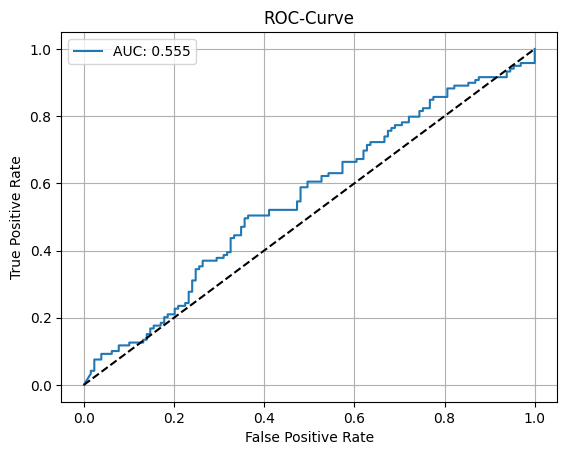

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
auc = roc_auc_score(val_trues, val_preds)
fpr, tpr, thresholds = roc_curve(val_trues, val_preds)
df_plot = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
plt.figure()
plt.plot(df_plot['fpr'], df_plot['tpr'], label='AUC: {a:0.3f}'.format(a=auc))
plt.plot([0,1], [0,1], color='black', linestyle='dashed')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve')
plt.legend()
plt.show()

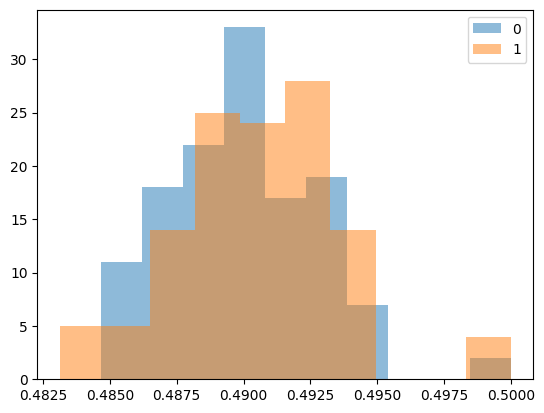

In [24]:
df_plot = pd.DataFrame({
    'trues': val_trues,
    'preds': val_preds
})
plt.figure()
for t, df_ in df_plot.groupby('trues'):
    plt.hist(df_['preds'], alpha=0.5, label=str(t))
plt.legend()
plt.show()

In [26]:
df_plot = pd.DataFrame({
    'trues': val_trues,
    'preds': val_preds
})
for th in np.linspace(val_preds.min(), val_preds.max(), 10):
    wins = (1-df_plot[df_plot['preds'] <= th]['trues']).sum()
    losses = (df_plot[df_plot['preds'] <= th]['trues']).sum()
    print(f'th: {round(th, 3)}, {wins}, {losses}, {round(wins/(wins+losses), 3)}')

th: 0.483, 0, 1, 0.0
th: 0.485, 4, 5, 0.444
th: 0.487, 19, 13, 0.594
th: 0.489, 42, 31, 0.575
th: 0.491, 83, 60, 0.58
th: 0.493, 102, 92, 0.526
th: 0.494, 124, 110, 0.53
th: 0.496, 127, 115, 0.525
th: 0.498, 127, 115, 0.525
th: 0.5, 129, 119, 0.52
